## Overview

Your assignment is to create a colorized river basin map for your country using the [HydroRIVERS](https://www.hydrosheds.org/products/hydrorivers) data.

This notebook contains code to download and pre-process the data. Your task is to plot the rivers using Matplotlib and achieve a unique style shown below.

<img src='https://courses.spatialthoughts.com/images/python_dataviz/assignment.png' width=800/>

## Setup and Data Download

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import requests
import zipfile

In [2]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [3]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
      with requests.get(url, stream=True, allow_redirects=True) as r:
          with open(filename, 'wb') as f:
              for chunk in r.iter_content(chunk_size=8192):
                  f.write(chunk)
      print('Downloaded', filename)


data_url = 'https://github.com/spatialthoughts/python-dataviz-web/releases/download/'

# This is a subset of the main HydroRivers dataset of all
# rivers having `UPLAND_SKM` value  greater than 100 sq. km.
hydrorivers_file = 'hydrorivers_100.gpkg'
hydrorivers_url = data_url + 'hydrosheds/'

countries_file = 'ne_10m_admin_0_countries_ind.zip'
countries_url = data_url + 'naturalearth/'


download(hydrorivers_url + hydrorivers_file)
download(countries_url + countries_file)


Downloaded data/hydrorivers_100.gpkg
Downloaded data/ne_10m_admin_0_countries_ind.zip


## Data Pre-Processing

Read the countries shapefile.

In [4]:
countries_filepath = os.path.join(data_folder, countries_file)

For the assignment, you need to pick the country for which you want to create the map. We can print a list of values from the `SOVEREIGNT` column of `country_gdf` GeoDataFrame using `country_gdf.SOVEREIGNT.values` to know the names of all countries.

In [5]:
country_gdf = gpd.read_file(countries_filepath)
print(sorted(country_gdf.SOVEREIGNT.unique()))

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bir Tawil', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brazilian Island', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Federated States of Micronesia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', '

Select a country name. Replace the value below with your chosen country.

In [6]:
country = 'Iran'

Apply filters to select the country feature. We use an additional filter `TYPE != 'Dependency'` to exclude overseas territories. You may have to adjust the filter to get the correct country polygon.

In [7]:
selected_country = country_gdf[
    (country_gdf['SOVEREIGNT'] == country) &
    (country_gdf['TYPE'] != 'Dependency')
]
selected_country

,ADM0_A3_IN,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
90,IRN,Admin-0 country,0,2,Iran,IRN,0,2,Sovereign country,1,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((44.80699 39.6399, 44.80965 39...."


We read the river network data from HydroRivers. We specify the `mask` parameter which clips the layer to the country boundary while reading the data.

*This step can take a few minutes depending on the size of the country.*

In [8]:
hydrorivers_filepath = os.path.join(data_folder, hydrorivers_file)
river_gdf = gpd.read_file(hydrorivers_filepath, mask=selected_country)
river_gdf

,HYRIV_ID,NEXT_DOWN,MAIN_RIV,LENGTH_KM,DIST_DN_KM,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,ORD_STRA,ORD_CLAS,ORD_FLOW,HYBAS_L12,geometry
0,20698521,20698520,20791150,1.35,1651.2,30.9,7.16,256.6,0,3.129,3,5,6,2121263040,"MULTILINESTRING ((46.01042 35.63125, 46.00625 ..."
1,20695286,20695285,20791150,2.38,1600.1,36.8,3.65,359.9,0,4.125,3,4,6,2120724990,"MULTILINESTRING ((45.81458 35.86458, 45.80625 ..."
2,20695285,20694881,20791150,5.08,1595.0,41.9,24.01,413.3,0,4.737,3,4,6,2120724990,"MULTILINESTRING ((45.79792 35.85625, 45.78542 ..."
3,20695220,20695286,20791150,12.19,1602.2,30.6,28.88,139.0,0,1.592,2,5,6,2120726430,"MULTILINESTRING ((45.92292 35.86875, 45.90208 ..."
4,20695151,20695286,20791150,3.95,1602.4,34.4,12.70,217.2,0,2.492,2,4,6,2120726320,"MULTILINESTRING ((45.84375 35.88958, 45.83958 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28109,20785029,20784893,20755687,1.62,302.5,155.0,10.00,6312.3,1,14.797,5,1,5,2121301670,"MULTILINESTRING ((56.36042 30.36458, 56.35625 ..."
28110,20785030,20785029,20755687,6.68,303.9,29.3,16.66,134.4,1,0.209,2,2,7,2120829950,"MULTILINESTRING ((56.41458 30.39375, 56.40625 ..."
28111,20784893,20784669,20755687,2.23,300.3,157.2,15.55,6346.9,1,14.820,5,1,5,2121301670,"MULTILINESTRING ((56.34792 30.37292, 56.34375 ..."
28112,20784669,20784238,20755687,4.72,295.6,161.9,22.59,6453.9,1,14.927,5,1,5,2121301670,"MULTILINESTRING ((56.33125 30.38542, 56.32708 ..."


Visualize the river network.

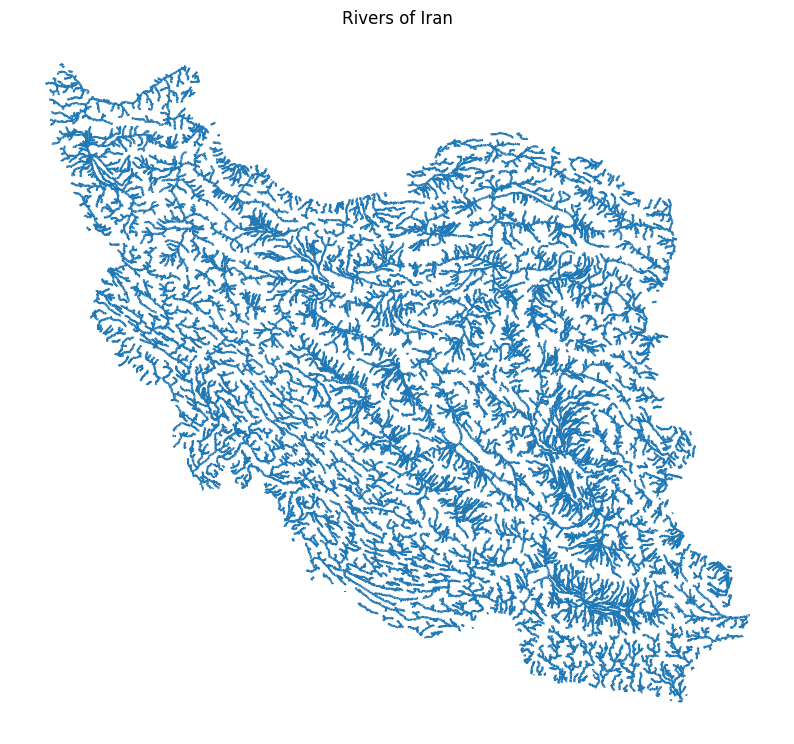

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
title = f'Rivers of {country}'
river_gdf.plot(ax=ax)
ax.set_title(title)
ax.set_axis_off()
plt.show()

We want to style the rivers so that the width of the line is proportional to the value in the `UPLAND_SKM` attribute. We add a new column `width` to the GeoDataFrame by scaling the input values to a range of target widths.

*Tip: These values will play an important role in your final visualization. Adjust these to suit the range of values for your country.*

In [10]:
original_min = 300
original_max = 10000
target_min = 0.2
target_max = 0.9
scaled = (river_gdf['UPLAND_SKM'] - original_min) / (original_max - original_min)
river_gdf['width'] = scaled.clip(0, 1) * (target_max - target_min) + target_min
river_gdf_final = river_gdf.sort_values(['UPLAND_SKM', 'width'])[
    ['MAIN_RIV', 'UPLAND_SKM', 'width', 'geometry']]
river_gdf_final

,MAIN_RIV,UPLAND_SKM,width,geometry
1799,20629151,100.1,0.2,"MULTILINESTRING ((47.89792 38.73125, 47.89792 ..."
3214,20834653,100.1,0.2,"MULTILINESTRING ((53.34792 27.11875, 53.35208 ..."
3492,20818816,100.1,0.2,"MULTILINESTRING ((54.30208 27.51458, 54.28958 ..."
4304,20801871,100.1,0.2,"MULTILINESTRING ((54.18958 29.34375, 54.18958 ..."
10591,20731570,100.1,0.2,"MULTILINESTRING ((53.40208 33.28125, 53.39375 ..."
...,...,...,...,...
4463,20791150,829495.0,0.9,"MULTILINESTRING ((48.40208 30.10208, 48.40625 ..."
4464,20791150,829522.9,0.9,"MULTILINESTRING ((48.42708 30.08542, 48.43542 ..."
4465,20791150,829557.6,0.9,"MULTILINESTRING ((48.43542 30.07708, 48.43958 ..."
4466,20791150,829590.7,0.9,"MULTILINESTRING ((48.44792 30.03958, 48.44792 ..."


Your task is to take the `river_gdf_final` GeoDataFrame and render the river network by applying the following styling guidelines. Refer to the [`geopandas.GeoDataFrame.plot()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html) documentation for parameter values and options.

* Assign a color to each river segment based on the value of `MAIN_RIV` column. *Hint: set `categorical=True`*.
* Assign width to each item based on the value in the `width` column.
* Set the map background to black.
* Set the title to white and change the font to be larger.